<a href="https://colab.research.google.com/github/pshoon25/Project_Jeju_Sales_Predict/blob/main/jeju_sales_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 제주도 관광객 수를 이용한 외식업 매출 회귀 분석
## 주제 선정 이유 : 
- 위드코로나로 인하여 타격이 컸던 외식업계도 점차 안정되어 있는 상황입니다. 수도권 및 육지의 경우 배달 서비스가 코로나의 돌파구가 되었습니다. 하지만 제주도의 경우 배달이 돌파구 역할을 해주지 못하였습니다. 
- 따라서 제주도의 외식업 매출분석을 통해 돌파구 역할을 해줄 수 있는 요소를 찾아보고자 하였습니다. 

## 사용한 자료 :
1. 업종별성별외식업이용정보.csv
https://www.jejudatahub.net/data/view/data/1047

2. Covid19InfState.csv
https://kdx.kr/data/view/3415

3. Covid19NatInfState.csv
https://kdx.kr/data/view/3415

4. 제주도 방문객수.csv
http://www.visitjeju.or.kr/web/bbs/bbsList.do?bbsId=TOURSTAT

## 1. 데이터 수집

In [ ]:
!mkdir /content/jeju
!wget -O /content/jeju/Jeju_Sales.csv https://github.com/youruchul/jeju_sales_predict/blob/main/업종별성별외식업이용정보.csv?raw=True
!wget -O /content/jeju/Covid19_Korea.csv https://github.com/youruchul/jeju_sales_predict/blob/main/Covid19InfState.csv?raw=True
!wget -O /content/jeju/Covid19_Global.csv https://github.com/youruchul/jeju_sales_predict/blob/main/Covid19NatInfState.csv?raw=True
!wget -O /content/jeju/Visitor.csv https://github.com/youruchul/jeju_sales_predict/blob/main/visitor.csv?raw=True

--2023-01-06 07:02:19--  https://github.com/youruchul/jeju_sales_predict/blob/main/%EC%97%85%EC%A2%85%EB%B3%84%EC%84%B1%EB%B3%84%EC%99%B8%EC%8B%9D%EC%97%85%EC%9D%B4%EC%9A%A9%EC%A0%95%EB%B3%B4.csv?raw=True
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/youruchul/jeju_sales_predict/raw/main/%EC%97%85%EC%A2%85%EB%B3%84%EC%84%B1%EB%B3%84%EC%99%B8%EC%8B%9D%EC%97%85%EC%9D%B4%EC%9A%A9%EC%A0%95%EB%B3%B4.csv [following]
--2023-01-06 07:02:19--  https://github.com/youruchul/jeju_sales_predict/raw/main/%EC%97%85%EC%A2%85%EB%B3%84%EC%84%B1%EB%B3%84%EC%99%B8%EC%8B%9D%EC%97%85%EC%9D%B4%EC%9A%A9%EC%A0%95%EB%B3%B4.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/youruchul/jeju_sales_predict/main/%EC%97%85%EC%A2%85%EB%B3%84%EC%84%B1%EB%B3%84%EC%99%B8%EC%8B%9D

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# seed 고정
np.random.seed(1234)

## 2. 데이터 전처리

### 업종별성별외식업이용정보.csv 파일에서 연월, 업종, 주문건수, 매출액 추출 후 sales_data 데이터프레임 생성
- sales_data : visit_date, category, sales



In [ ]:
df = pd.read_csv("/content/jeju/Jeju_Sales.csv")
df = df.drop(['소분류업종명','성별', '이용자수'], axis = 1)
df = df.groupby(['연월','중분류업종명']).sum()
sales_data = df.reset_index()
sales_data.columns=["visit_date","category","counts","sales"]
sales_data['visit_date']=sales_data['visit_date'].astype(str)
sales_data.drop(["counts"],axis=1,inplace=True)
sales_data

,visit_date,category,sales
0,201901,간이주점,12436278384
1,201901,고기요리,30205246488
2,201901,닭/오리요리,13648529052
3,201901,별식/퓨전요리,3504780554
4,201901,부페,1430727132
...,...,...,...
457,202109,제과/제빵/떡/케익,15554446377
458,202109,중식,9533306679
459,202109,커피/음료,29626167113
460,202109,패스트푸드,10723273794


### Covid19InfState.csv에서 연월, 국내 코로나 확진수 추출 후 covid_local_data 데이터프레임 생성
- covid_local_data : visit_date, covid_local

In [ ]:
df = pd.read_csv("/content/jeju/Covid19_Korea.csv")
df = df[['decideCnt','stateDt']]
df.loc[[933],["decideCnt"]] = 10718.0
df.loc[[1049],["decideCnt"]] = 0.0

yearmon = []
for i in df['stateDt'] :
  yearmon.append(str(i)[:6])
df['visit_date'] = yearmon
covid_local_data = df.loc[:,['visit_date','decideCnt']]
covid_local_data = covid_local_data.groupby(by=['visit_date']).max()

covid_local_data = covid_local_data.reset_index()

for i in range (0,36,1) :
    if i == 0 :
        covid_local_data.loc[i,'covid_local'] = 0
        continue
    else:
        covid_local_data.loc[i,'covid_local'] = covid_local_data.loc[i,'decideCnt'] - covid_local_data.loc[(i-1),'decideCnt'] 

covid_local_data.drop(["decideCnt"],axis=1,inplace=True)

li = [str(i) for i in range(201901,201913)]
df = pd.DataFrame({"visit_date":li,"covid_local":0.0})

covid_local_data = pd.concat([df,covid_local_data],axis=0)
covid_local_data['visit_date']=covid_local_data['visit_date'].astype(str)
covid_local_data

,visit_date,covid_local
0,201901,0.0
1,201902,0.0
2,201903,0.0
3,201904,0.0
4,201905,0.0
5,201906,0.0
6,201907,0.0
7,201908,0.0
8,201909,0.0
9,201910,0.0


### Covid19NatInfState.csv에서 연월, 중국 코로나 확진수, 일본 코로나 확진수 추출 후 covid_global_data 데이터프레임 생성
- covid_global_data : visit_date, covid_china, covid_japan

In [ ]:
df = pd.read_csv("/content/jeju/Covid19_Global.csv")
# 안쓰는 컬럼 제거
df = df[['stdDay', 'nationNm','natDefCnt']]
# 국가명이 '일본'인 행만 추출 후 새로운 DataFrame으로 만듬
df_japan = df[(df['nationNm']=='일본')]
# 국가명이 '중국'인 행만 추출 후 새로운 DataFrame으로 만듬
df_china = df[(df['nationNm']=='중국')]

# 일별 누적 확진자를 월별 누적확진자로 변경
yearmon = []
for i in df_china['stdDay'] :
  yearmon.append(str(i)[:9])
df_china['연월'] = yearmon
df_china = df_china.loc[:,['연월','nationNm', 'natDefCnt']]
df_china = df_china.groupby(by=['연월']).max()

# 이상치 제거
mask1 = df_china['natDefCnt'].isin([81340.0])
df_china = df_china[~mask1]
df_china = df_china.reset_index()

# 월별 누적 확진자를 월별 확진자로 변경
new_df_china = df_china
for i in range (0,34,1) :
    if i == 0 :
      new_df_china.loc[i,'covid_china'] = new_df_china.loc[0,'natDefCnt']
      continue
    else:
        new_df_china.loc[i,'covid_china'] = new_df_china.loc[i,'natDefCnt'] - new_df_china.loc[(i-1),'natDefCnt'] 
df_china = new_df_china

# 일별 누적 확진자를 월별 누적확진자로 변경
yearmon2 = []
for i in df_japan['stdDay'] :
  yearmon2.append(str(i)[:9])
df_japan['연월'] = yearmon2
df_japan = df_japan.loc[:,['연월','nationNm', 'natDefCnt']]
df_japan = df_japan.groupby(by=['연월']).max()

# 이상치 제거
mask = df_japan['natDefCnt'].isin([1387.0])
df_japan = df_japan[~mask]
df_japan = df_japan.reset_index()

# 월별 누적 확진자를 월별 확진자로 변경
new_df_japan = df_japan
for i in range (0,34,1) :
    if i == 0 :
      new_df_japan.loc[i,'covid_china'] = new_df_japan.loc[0,'natDefCnt']
      continue
    else:
        new_df_japan.loc[i,'covid_china'] = new_df_japan.loc[i,'natDefCnt'] - new_df_japan.loc[(i-1),'natDefCnt'] 
df_japan = new_df_japan

df_china.replace('년', '',  regex=True,inplace=True)
df_china.replace('월', '',  regex=True,inplace=True)
df_china.replace(' ', '',  regex=True,inplace=True)

df_japan.replace('년', '',  regex=True,inplace=True)
df_japan.replace('월', '',  regex=True,inplace=True)
df_japan.replace(' ', '',  regex=True,inplace=True)

covid_global_data = pd.merge(df_china,df_japan,on='연월')

covid_global_data.drop(["nationNm_x","natDefCnt_x","nationNm_y","natDefCnt_y"],axis=1,inplace=True)

covid_global_data.columns = ["visit_date","covid_china","covid_japan"]
covid_global_data['visit_date']=covid_global_data['visit_date'].astype(str)
covid_global_data

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-6-59662552b7d4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_china['연월'] = yearmon
<ipython-input-6-59662552b7d4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_japan['연월'] = yearmon2


,visit_date,covid_china,covid_japan
0,202003,81518.0,1953.0
1,202004,1344.0,12135.0
2,202005,139.0,2763.0
3,202006,530.0,1742.0
4,202007,761.0,15779.0
5,202008,756.0,33493.0
6,202009,355.0,14629.0
7,202010,570.0,17128.0
8,202011,569.0,47138.0
9,202012,510.0,79836.0


### - 제주도 방문객수.csv에서 연월, 내국인 방문객 수, 외국인 방문객 수 추출 후 visitor_data 데이터프레임 생성 
- visitor_data : visit_date, visitor_local, visitor_foreigner

In [ ]:
visitor_data = pd.read_csv("/content/jeju/Visitor.csv")
visitor_data['visit_date']=visitor_data['visit_date'].astype(str)
visitor_data

,visit_date,visitor_local,visitor_foreigner
0,201801,1044956,57422
1,201802,892863,57046
2,201803,1033778,80615
3,201804,1224521,86682
4,201805,1205904,91071
5,201806,1178012,115716
6,201807,1122890,114159
7,201808,1146756,131772
8,201809,1098591,122998
9,201810,1128247,135475


### 데이터프레임 병합하여 jeju_dataset 데이터프레임 생성 
- jeju_dataset : visit_date, category, covid_local, covid_china, covid_japan, visitor_local, visitor_foreigner, sales

In [ ]:
jeju_dataset = pd.merge(sales_data,covid_local_data,on='visit_date', how='left')
jeju_dataset = pd.merge(jeju_dataset,covid_global_data,on='visit_date', how='left')
jeju_dataset = pd.merge(jeju_dataset,visitor_data,on='visit_date', how='left')

a = jeju_dataset.pop("sales")
jeju_dataset["sales"] = a
jeju_dataset = jeju_dataset.fillna(0)
jeju_dataset

,visit_date,category,covid_local,covid_china,covid_japan,visitor_local,visitor_foreigner,sales
0,201901,간이주점,0.0,0.0,0.0,1024130,106713,12436278384
1,201901,고기요리,0.0,0.0,0.0,1024130,106713,30205246488
2,201901,닭/오리요리,0.0,0.0,0.0,1024130,106713,13648529052
3,201901,별식/퓨전요리,0.0,0.0,0.0,1024130,106713,3504780554
4,201901,부페,0.0,0.0,0.0,1024130,106713,1430727132
...,...,...,...,...,...,...,...,...
457,202109,제과/제빵/떡/케익,59868.0,1249.0,243267.0,867371,5025,15554446377
458,202109,중식,59868.0,1249.0,243267.0,867371,5025,9533306679
459,202109,커피/음료,59868.0,1249.0,243267.0,867371,5025,29626167113
460,202109,패스트푸드,59868.0,1249.0,243267.0,867371,5025,10723273794


### jeju_dataset에서 train_jeju(19년도1월-21년도3월,26개월분)와 test_jeju(21년도4월-21년도9월,6개월분) 분리
- train_jeju_dataset : visit_date, category, covid_local, covid_china, covid_japan, visitor_local, visitor_foreigner, sales
- test_jeju_dataset : visit_date, category, covid_local, covid_china, covid_japan, visitor_local, visitor_foreigner, sales

In [ ]:
train_jeju_dataset = jeju_dataset[:378]
train_jeju_dataset

,visit_date,category,covid_local,covid_china,covid_japan,visitor_local,visitor_foreigner,sales
0,201901,간이주점,0.0,0.0,0.0,1024130,106713,12436278384
1,201901,고기요리,0.0,0.0,0.0,1024130,106713,30205246488
2,201901,닭/오리요리,0.0,0.0,0.0,1024130,106713,13648529052
3,201901,별식/퓨전요리,0.0,0.0,0.0,1024130,106713,3504780554
4,201901,부페,0.0,0.0,0.0,1024130,106713,1430727132
...,...,...,...,...,...,...,...,...
373,202103,제과/제빵/떡/케익,13412.0,308.0,39636.0,889216,4110,14525294923
374,202103,중식,13412.0,308.0,39636.0,889216,4110,8969828555
375,202103,커피/음료,13412.0,308.0,39636.0,889216,4110,24515816060
376,202103,패스트푸드,13412.0,308.0,39636.0,889216,4110,8360920232


In [ ]:
test_jeju_dataset = jeju_dataset[378:]
test_jeju_dataset = test_jeju_dataset.reset_index()
test_jeju_dataset.drop(["index"],axis=1,inplace=True)
test_jeju_dataset

,visit_date,category,covid_local,covid_china,covid_japan,visitor_local,visitor_foreigner,sales
0,202104,간이주점,18919.0,464.0,110813.0,1078759,4102,12879746520
1,202104,고기요리,18919.0,464.0,110813.0,1078759,4102,31467849684
2,202104,닭/오리요리,18919.0,464.0,110813.0,1078759,4102,12238165487
3,202104,별식/퓨전요리,18919.0,464.0,110813.0,1078759,4102,3488058738
4,202104,부페,18919.0,464.0,110813.0,1078759,4102,703352052
...,...,...,...,...,...,...,...,...
79,202109,제과/제빵/떡/케익,59868.0,1249.0,243267.0,867371,5025,15554446377
80,202109,중식,59868.0,1249.0,243267.0,867371,5025,9533306679
81,202109,커피/음료,59868.0,1249.0,243267.0,867371,5025,29626167113
82,202109,패스트푸드,59868.0,1249.0,243267.0,867371,5025,10723273794


### new_jeju_dataset 생성
- new_jeju_dataset : visit_date, category, covid_local, covid_china, covid_japan, visitor_local, visitor_foreigner

In [ ]:
visit_date = []
for i in ["202110","202111","202112"]:
  for j in range(14):
    visit_date.append(i)

new_jeju_dataset = pd.DataFrame({"visit_date":visit_date,"category":test_jeju_dataset["category"][:42]})

new_jeju_dataset = pd.merge(new_jeju_dataset,covid_local_data,on='visit_date', how='left')
new_jeju_dataset = pd.merge(new_jeju_dataset,covid_global_data,on='visit_date', how='left')
new_jeju_dataset = pd.merge(new_jeju_dataset,visitor_data,on='visit_date', how='left')

new_jeju_dataset

,visit_date,category,covid_local,covid_china,covid_japan,visitor_local,visitor_foreigner
0,202110,간이주점,53411.0,952.0,20349.0,1218155,3939
1,202110,고기요리,53411.0,952.0,20349.0,1218155,3939
2,202110,닭/오리요리,53411.0,952.0,20349.0,1218155,3939
3,202110,별식/퓨전요리,53411.0,952.0,20349.0,1218155,3939
4,202110,부페,53411.0,952.0,20349.0,1218155,3939
5,202110,분식,53411.0,952.0,20349.0,1218155,3939
6,202110,양식,53411.0,952.0,20349.0,1218155,3939
7,202110,유흥주점,53411.0,952.0,20349.0,1218155,3939
8,202110,일식/수산물,53411.0,952.0,20349.0,1218155,3939
9,202110,제과/제빵/떡/케익,53411.0,952.0,20349.0,1218155,3939


## 3. 데이터 시각화

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-13-869ebe828574>:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  visit_data = jeju_dataset.groupby('visit_date')['visitor_local', 'visitor_foreigner'].sum()
<ipython-input-13-869ebe828574>:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  covid_data = jeju_dataset.groupby('visit_date')['covid_local', 'covid_china',	'covid_japan'].sum()


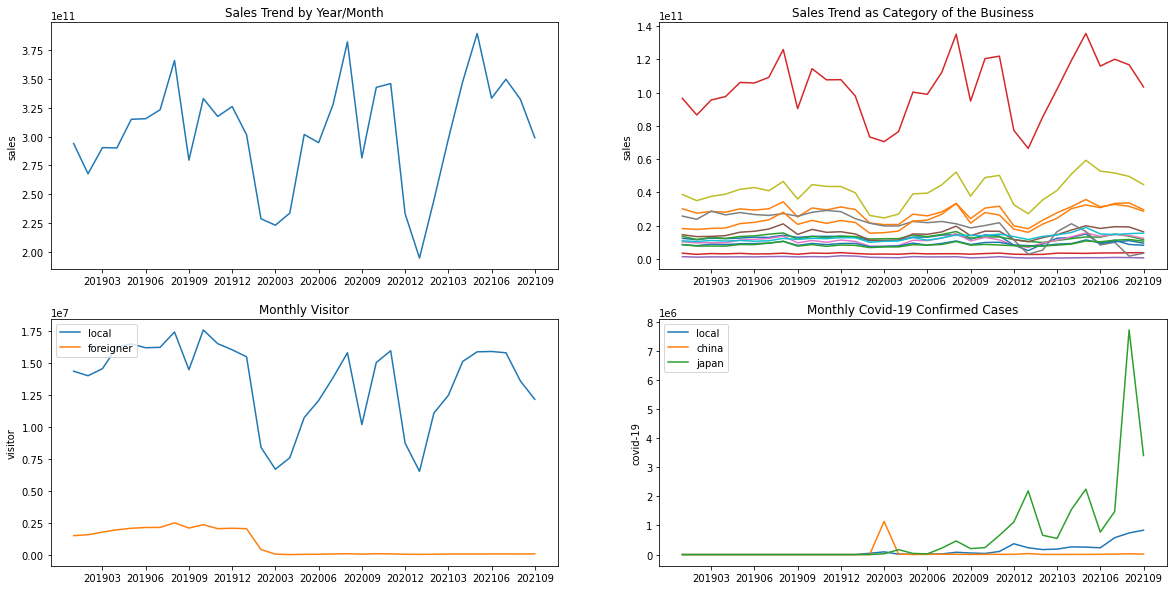

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

# Sales Trend by Year/Month
sales_data = jeju_dataset.groupby('visit_date')['sales'].sum()

ax[0][0].plot(sales_data.index.astype('str'), sales_data.values)

# Sales Trend as Category of the Business
x = jeju_dataset['visit_date'].unique()
category_data = jeju_dataset.groupby(['visit_date', 'category'])['sales'].sum()
category_data = category_data.reset_index()
cat_unique = category_data['category'].unique()
x = x.astype('str')

for i in cat_unique :
  ax[0][1].plot(x, category_data.loc[category_data['category'] == i, 'sales'])

# Monthly Visitor
visit_data = jeju_dataset.groupby('visit_date')['visitor_local', 'visitor_foreigner'].sum()
ax[1][0].plot(visit_data.index.astype('str'), visit_data.iloc[:, 0])
ax[1][0].plot(visit_data.index.astype('str'), visit_data.iloc[:, 1])

# Monthly Covid-19 Confirmed Cases
covid_data = jeju_dataset.groupby('visit_date')['covid_local', 'covid_china',	'covid_japan'].sum()
covid_data
ax[1][1].plot(covid_data.index.astype('str'), covid_data.iloc[:, 0])
ax[1][1].plot(covid_data.index.astype('str'), covid_data.iloc[:, 1])
ax[1][1].plot(covid_data.index.astype('str'), covid_data.iloc[:, 2])

# seting
ax[0,0].set_xticks(["201903","201906","201909","201912","202003","202006","202009","202012","202103","202106","202109"])
ax[0,1].set_xticks(["201903","201906","201909","201912","202003","202006","202009","202012","202103","202106","202109"])
ax[1,0].set_xticks(["201903","201906","201909","201912","202003","202006","202009","202012","202103","202106","202109"])
ax[1,1].set_xticks(["201903","201906","201909","201912","202003","202006","202009","202012","202103","202106","202109"])

ax[0,0].set_ylabel("sales")
ax[0,1].set_ylabel("sales")
ax[1,0].set_ylabel("visitor")
ax[1,1].set_ylabel("covid-19")

ax[0, 0].set_title("Sales Trend by Year/Month")
ax[0, 1].set_title("Sales Trend as Category of the Business")
ax[1, 0].set_title("Monthly Visitor")
ax[1, 1].set_title("Monthly Covid-19 Confirmed Cases")

ax[1,0].legend(["local","foreigner"],loc='upper left')
ax[1,1].legend(["local","china","japan"],loc='upper left')

### 시각화를 통한 결과 예상

- 제주도 관광은 계절의 영향을 많이 받는다. 항상 12월에서 3월사이에 매출이 적음.
- 해외방문자의 감소는 매출에 큰 영향을 미치지 않는다. ==> visitor_foreigner 독립변수 제거
- 중국 코로나가 발발했을 때 매출에 큰 타격이 있었고, 그 후 국내 코로나 확진자 급증에 의한 매출 감소가 발생하였다. ==> covid_japan 독립변수 제거
- 매출에 가장 큰 폭을 차지하는 부분은 간이주점( ..,., )이며 그 다음순으로는 고기, 닭/오리 요리 주점이다. 간이주점에 매출이 전체 매출에 가장 큰 영향을 미친다.

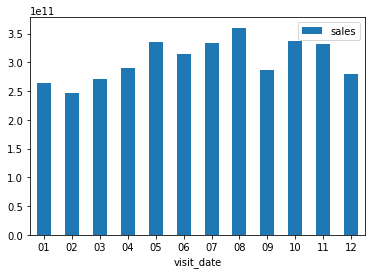

In [ ]:
jeju_mean = jeju_dataset.copy()
# 날짜의 년 부분 제거
jeju_mean['visit_date'].replace('2020', '',  regex=True,inplace=True)
jeju_mean['visit_date'].replace('2021', '',  regex=True,inplace=True)
jeju_mean['visit_date'].replace('2022', '',  regex=True,inplace=True)
jeju_mean['visit_date'].replace('2018', '',  regex=True,inplace=True)
jeju_mean['visit_date'].replace('2019', '',  regex=True,inplace=True)
# 월별, 카테고리별 평균을 구하기
jeju_mean = jeju_mean.groupby(['visit_date','category']).mean()
jeju_mean = jeju_mean.reset_index()
# 카테고리 제거후 월별 매출 평균 구하기 (같은 월의 카테고리별 평균매출을 더함)
jeju_mean = jeju_mean.drop(['category'],axis=1)
jeju_total_mean = jeju_mean.groupby(['visit_date']).sum()
# 필요없는 컬럼 제거
jeju_total_mean = jeju_total_mean.drop(['covid_local','covid_china','covid_japan','visitor_foreigner','visitor_local'], axis= 1)
jeju_total_mean = jeju_total_mean.reset_index()
jeju_total_mean
#시각화
jeju_total_mean.plot.bar(x='visit_date', y='sales', rot=0)

### 해외 데이터 제외
- train_jeju_dataset : visit_date, category, covid_local, covid_china, visitor_local, sales
- test_jeju_dataset : visit_date, category, covid_local, covid_china,visitor_local, sales
- new_jeju_dataset : visit_date, category, covid_local, covid_china,visitor_local

In [ ]:
train_jeju_dataset = train_jeju_dataset[['visit_date', 'category','covid_local','covid_china','visitor_local','sales']]
test_jeju_dataset = test_jeju_dataset[['visit_date', 'category','covid_local','covid_china','visitor_local','sales']]
new_jeju_dataset = new_jeju_dataset[['visit_date', 'category','covid_local','covid_china','visitor_local']]

### 카테고리 원핫인코딩

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train_data = train_jeju_dataset["category"].values
test_data = test_jeju_dataset["category"].values
new_data = new_jeju_dataset["category"].values

# 2차원으로 변경
train_data = np.array(train_data)
test_data = np.array(test_data)
new_data = np.array(new_data)

train_data = train_data[..., np.newaxis] # ndarray타입이어야 된다.
test_data = test_data[..., np.newaxis] # ndarray타입이어야 된다.
new_data = new_data[..., np.newaxis] # ndarray타입이어야 된다.

In [ ]:
encoder = OneHotEncoder()
encoder.fit(train_data)
train_data_oh = encoder.transform(train_data)
test_data_oh = encoder.transform(test_data)
new_data_oh = encoder.transform(new_data)

In [ ]:
train_data_oh_df = pd.DataFrame(train_data_oh.toarray())
test_data_oh_df = pd.DataFrame(test_data_oh.toarray())
new_data_oh_df = pd.DataFrame(new_data_oh.toarray())
'''
간이주점         #category1
고기요리         #category2
닭/오리요리       #category3
별식/퓨전요리     #category4
부페            #category5
분식            #category6
양식            #category7
유흥주점         #category8
일식/수산물       #category9
제과/제빵/떡/케익  #category10
중식            #category11
커피/음료        #category12
패스트푸드        #category13
한식            #category14
'''
cate_list = ["category1","category2","category3","category4","category5","category6","category7",
                 "category8","category9","category10","category11","category12","category13","category14"]
train_data_oh_df.columns = cate_list
test_data_oh_df.columns = cate_list
new_data_oh_df.columns = cate_list

In [ ]:
train_jeju_dataset = pd.concat([train_jeju_dataset,train_data_oh_df],axis=1)
train_jeju_dataset.drop("category", axis=1,inplace=True)
a = train_jeju_dataset.pop("sales")
train_jeju_dataset["sales"] = a
train_jeju_dataset

,visit_date,covid_local,covid_china,visitor_local,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,category11,category12,category13,category14,sales
0,201901,0.0,0.0,1024130,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12436278384
1,201901,0.0,0.0,1024130,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30205246488
2,201901,0.0,0.0,1024130,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13648529052
3,201901,0.0,0.0,1024130,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3504780554
4,201901,0.0,0.0,1024130,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1430727132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,202103,13412.0,308.0,889216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14525294923
374,202103,13412.0,308.0,889216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8969828555
375,202103,13412.0,308.0,889216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24515816060
376,202103,13412.0,308.0,889216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8360920232


In [ ]:
test_jeju_dataset = pd.concat([test_jeju_dataset,test_data_oh_df],axis=1)
test_jeju_dataset.drop("category", axis=1,inplace=True)
a = test_jeju_dataset.pop("sales")
test_jeju_dataset["sales"] = a
test_jeju_dataset

,visit_date,covid_local,covid_china,visitor_local,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,category11,category12,category13,category14,sales
0,202104,18919.0,464.0,1078759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12879746520
1,202104,18919.0,464.0,1078759,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31467849684
2,202104,18919.0,464.0,1078759,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12238165487
3,202104,18919.0,464.0,1078759,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3488058738
4,202104,18919.0,464.0,1078759,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,703352052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,202109,59868.0,1249.0,867371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15554446377
80,202109,59868.0,1249.0,867371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9533306679
81,202109,59868.0,1249.0,867371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29626167113
82,202109,59868.0,1249.0,867371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10723273794


In [ ]:
new_jeju_dataset = pd.concat([new_jeju_dataset,new_data_oh_df],axis=1)
new_jeju_dataset.drop("category", axis=1,inplace=True)
new_jeju_dataset

,visit_date,covid_local,covid_china,visitor_local,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,category11,category12,category13,category14
0,202110,53411.0,952.0,1218155,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,202110,53411.0,952.0,1218155,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,202110,53411.0,952.0,1218155,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,202110,53411.0,952.0,1218155,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,202110,53411.0,952.0,1218155,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,202110,53411.0,952.0,1218155,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,202110,53411.0,952.0,1218155,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,202110,53411.0,952.0,1218155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,202110,53411.0,952.0,1218155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,202110,53411.0,952.0,1218155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 4. 데이터 분류

In [ ]:
jeju_data = train_jeju_dataset.iloc[:,:-1]
jeju_target = train_jeju_dataset.iloc[:,-1]
jeju_data.shape, jeju_target.shape

((378, 18), (378,))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(jeju_data, jeju_target, test_size=0.3, random_state=1)

In [ ]:
X_train.shape, y_train.shape

((264, 18), (264,))

In [ ]:
X_test.shape, y_test.shape

((114, 18), (114,))

#### 테스트 데이터

In [ ]:
test_jeju_data = test_jeju_dataset.iloc[:,:-1]
test_jeju_target = test_jeju_dataset.iloc[:,-1]
test_jeju_data.shape, test_jeju_target.shape

((84, 18), (84,))

## 5. 표준화

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()
sc.fit(X_train)
train_scaled = sc.transform(X_train)
valid_scaled = sc.transform(X_test)
test_scaled = sc.transform(test_jeju_data)
new_scaled = sc.transform(new_jeju_dataset)

## 6. 모델 생성/학습/평가

### 1) LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(train_scaled, y_train)

LinearRegression()

In [ ]:
lr.score(train_scaled, y_train)

0.9506482062522714

In [ ]:
lr.score(valid_scaled, y_test)

0.974797470231579

In [ ]:
from sklearn.metrics import mean_absolute_error
pred = lr.predict(valid_scaled)
mae = mean_absolute_error(y_test, pred)
print("mae:{}".format(mae))

mae:2933021922.854266


#### 테스트 데이터

In [ ]:
lr.score(test_scaled, test_jeju_target)

0.9154981222227465

In [ ]:
pred = lr.predict(test_scaled)
lr_mae = mean_absolute_error(test_jeju_target, pred)
print("mae:{}".format(lr_mae))

mae:5980405809.585727


### 2) Ridge

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
rg = Ridge()
rg.fit(train_scaled, y_train)

Ridge()

#### 최적 알파값 찾기

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params ={'alpha':np.arange(0.1,10,0.1)} # 100

In [ ]:
clf = RandomizedSearchCV(rg,
                         param_distributions=params,
                         scoring="neg_mean_absolute_error",
                         n_jobs=-1,
                         refit=True,
                         cv=5,
                         verbose=1,
                         return_train_score=True,
                         n_iter=500,
                         random_state=1)
clf.fit(train_scaled, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 99 is smaller than n_iter=500. Running 99 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
                   random_state=1, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
clf.best_score_

-3130215630.5903816

In [ ]:
clf.best_params_

{'alpha': 2.3000000000000003}

In [ ]:
rg = clf.best_estimator_
rg

Ridge(alpha=2.3000000000000003)

In [ ]:
rg.score(train_scaled, y_train)

0.9505781909410165

In [ ]:
rg.score(valid_scaled, y_test)

0.9743946349134808

In [ ]:
from sklearn.metrics import mean_absolute_error
pred = rg.predict(valid_scaled)
mae = mean_absolute_error(y_test, pred)
print("mae:{}".format(mae))

mae:2920242554.4971833


#### 테스트 데이터

In [ ]:
rg.score(test_scaled, test_jeju_target)

0.9122977404486007

In [ ]:
pred = rg.predict(test_scaled)
rg_mae = mean_absolute_error(test_jeju_target, pred)
print("mae:{}".format(rg_mae))

mae:6049056783.804174


### 3) XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(train_scaled,y_train)

[07:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.08, max_depth=7, subsample=0.75)

In [ ]:
xgb.score(train_scaled, y_train)

0.9993907372266083

In [ ]:
xgb.score(valid_scaled, y_test)

0.9912681637158867

In [ ]:
from sklearn.metrics import mean_absolute_error
pred = xgb.predict(valid_scaled)
mae = mean_absolute_error(y_test, pred)
print("mae:{}".format(mae))

mae:1564183415.008772


#### 테스트 데이터

In [ ]:
xgb.score(test_scaled, test_jeju_target)

0.9714986517095305

In [ ]:
pred = xgb.predict(test_scaled)
xgb_mae = mean_absolute_error(test_jeju_target, pred)
print("mae:{}".format(xgb_mae))

mae:3264816786.0833335


### 4) LightGBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
lgbm.fit(train_scaled,y_train)

LGBMRegressor(colsample_bytree=1, gamma=0, learning_rate=0.08, max_depth=7,
              subsample=0.75)

In [ ]:
lgbm.score(train_scaled, y_train)

0.19306205702982004

In [ ]:
lgbm.score(valid_scaled, y_test)

-0.08040890997642691

In [ ]:
from sklearn.metrics import mean_absolute_error
pred = lgbm.predict(valid_scaled)
mae = mean_absolute_error(y_test, pred)
print("mae:{}".format(mae))

mae:18266018361.70786


#### 테스트 데이터

In [ ]:
lgbm.score(test_scaled, test_jeju_target)

0.08666319716061621

In [ ]:
pred = lgbm.predict(test_scaled)
lgbm_mae = mean_absolute_error(test_jeju_target, pred)
print("mae:{}".format(lgbm_mae))

mae:15646224538.60943


## 7. 최우수 모델 선정

### 모댈별 mae 값 막대그래프

In [ ]:
mae_df = pd.DataFrame({"model":["LinearRegression","Ridge","XGBRegressor","LGBMRegressor"],"mae":[lr_mae,rg_mae,xgb_mae,lgbm_mae]})
mae_df

,model,mae
0,LinearRegression,5.980406e+09
1,Ridge,6.049057e+09
2,XGBRegressor,3.264817e+09
3,LGBMRegressor,1.564622e+10


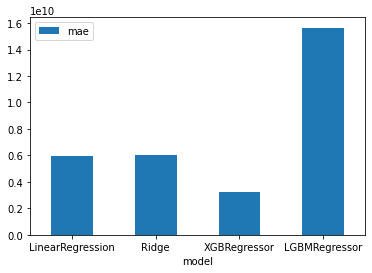

In [ ]:
mae_df.plot.bar(x='model', y='mae', rot=0)

### 1) LinearRegression

In [ ]:
lr_pred = lr.predict(new_scaled)
lr_pred_7to9 = lr.predict(test_scaled[42:])
lr_pred_7to9

array([ 1.28988777e+10,  2.80976500e+10,  1.38635165e+10,  3.41817646e+09,
        1.73988470e+09,  1.58859464e+10,  1.18395378e+10,  2.21793075e+10,
        4.03771333e+10,  1.31116729e+10,  9.59123289e+09,  2.22035041e+10,
        8.86931185e+09,  9.86519461e+10,  9.41726219e+09,  2.46160345e+10,
        1.03819010e+10, -6.34390634e+07, -1.74173082e+09,  1.24043309e+10,
        8.35792231e+09,  1.86976919e+10,  3.68955178e+10,  9.63005733e+09,
        6.10961737e+09,  1.87218885e+10,  5.38769633e+09,  9.51703306e+10,
        7.21672129e+09,  2.24154936e+10,  8.18136006e+09, -2.26397996e+09,
       -3.94227172e+09,  1.02037900e+10,  6.15738142e+09,  1.64971511e+10,
        3.46949769e+10,  7.42951644e+09,  3.90907647e+09,  1.65213476e+10,
        3.18715544e+09,  9.29697897e+10])

### 2) XGBoost

In [ ]:
xgb_pred = xgb.predict(new_scaled)
xgb_pred_7to9 = xgb.predict(test_scaled[42:])

### 새로운 데이터 그래프

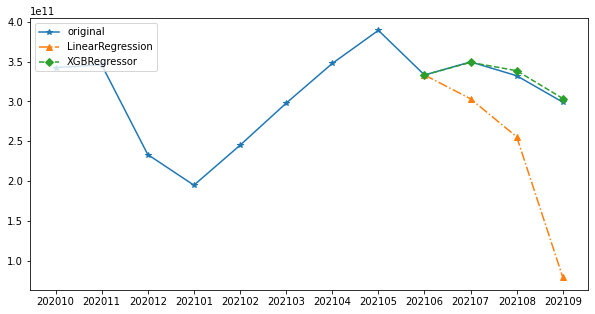

In [ ]:
jeju_sales = jeju_dataset.groupby('visit_date')['sales'].sum()
jeju_sales_2019_9 = jeju_sales[-12:].reset_index()
jeju_sales_2019_9

date_list = ["202106","202107","202108","202109"]
lr_sales = [333202593889,lr_pred[:14].sum(), lr_pred[14:28].sum(), lr_pred[28:].sum()]
xgb_sales = [333202593889,xgb_pred[:14].sum(), xgb_pred[14:28].sum(), xgb_pred[28:].sum()]

lr_pred_df = pd.DataFrame({"visit_date":date_list,"sales":lr_sales})
xgb_pred_df = pd.DataFrame({"visit_date":date_list,"sales":xgb_sales})

fig= plt.subplots(figsize=(10,5))

plt.plot(jeju_sales_2019_9["visit_date"], jeju_sales_2019_9["sales"], marker="*")
plt.plot(lr_pred_df["visit_date"], lr_pred_df["sales"], linestyle="-.", marker="^")
plt.plot(xgb_pred_df["visit_date"], xgb_pred_df["sales"], linestyle="--", marker="D")

plt.legend(["original","LinearRegression","XGBRegressor"],loc='upper left')